In [1]:
!pip uninstall keras -y
!pip install keras==2.2.5
!pip install segmentation-models --quiet
!pip install tta-wrapper --quiet

Uninstalling Keras-2.2.5:
  Successfully uninstalled Keras-2.2.5
  Using cached https://files.pythonhosted.org/packages/f8/ba/2d058dcf1b85b9c212cc58264c98a4a7dd92c989b798823cc5690d062bb2/Keras-2.2.5-py2.py3-none-any.whl


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.listdir('/content/drive/My Drive/CS583FinalProject')
os.chdir('/content/drive/My Drive/CS583FinalProject')

In [4]:
import os
import json

import albumentations as albu
import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from skimage.exposure import adjust_gamma
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import segmentation_models as sm

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
import keras.backend as K
from keras.legacy import interfaces
from keras.optimizers import Optimizer
import tensorflow as tf
class AdamAccumulate(Optimizer):

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., amsgrad=False, accum_iters=1, **kwargs):
        if accum_iters < 1:
            raise ValueError('accum_iters must be >= 1')
        super(AdamAccumulate, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsgrad = amsgrad
        self.accum_iters = K.variable(accum_iters, K.dtype(self.iterations))
        self.accum_iters_float = K.cast(self.accum_iters, K.floatx())

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr

        completed_updates = K.cast(tf.math.floordiv(self.iterations, self.accum_iters), K.floatx())

        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * completed_updates))

        t = completed_updates + 1

        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) / (1. - K.pow(self.beta_1, t)))

        # self.iterations incremented after processing a batch
        # batch:              1 2 3 4 5 6 7 8 9
        # self.iterations:    0 1 2 3 4 5 6 7 8
        # update_switch = 1:        x       x    (if accum_iters=4)  
        update_switch = K.equal((self.iterations + 1) % self.accum_iters, 0)
        update_switch = K.cast(update_switch, K.floatx())

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        gs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        else:
            vhats = [K.zeros(1) for _ in params]

        self.weights = [self.iterations] + ms + vs + vhats

        for p, g, m, v, vhat, tg in zip(params, grads, ms, vs, vhats, gs):

            sum_grad = tg + g
            avg_grad = sum_grad / self.accum_iters_float

            m_t = (self.beta_1 * m) + (1. - self.beta_1) * avg_grad
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(avg_grad)

            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                p_t = p - lr_t * m_t / (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, (1 - update_switch) * vhat + update_switch * vhat_t))
            else:
                p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon)

            self.updates.append(K.update(m, (1 - update_switch) * m + update_switch * m_t))
            self.updates.append(K.update(v, (1 - update_switch) * v + update_switch * v_t))
            self.updates.append(K.update(tg, (1 - update_switch) * sum_grad))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, (1 - update_switch) * p + update_switch * new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'amsgrad': self.amsgrad}
        base_config = super(AdamAccumulate, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((350, 525), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

# Preprocessing

In [7]:
train_df = pd.read_csv('train.csv')
train_df['ImageId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()

print(train_df.shape)
train_df.head()

(22184, 5)


,Image_Label,EncodedPixels,ImageId,ClassId,hasMask
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,True
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,True
2,0011165.jpg_Gravel,NaN,0011165.jpg,Gravel,False
3,0011165.jpg_Sugar,NaN,0011165.jpg,Sugar,False
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish,True


In [8]:
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(5546, 2)


,ImageId,hasMask
821,24dd99c.jpg,4.0
1885,562f80a.jpg,4.0
3260,944f10b.jpg,4.0
1872,55b539f.jpg,4.0
4464,cdf7242.jpg,4.0


In [0]:
sub_df = pd.read_csv('sample_submission.csv')
sub_df['ImageId'] = sub_df['Image_Label'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])

# Utility Functions

Source: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

Unhide below for the definition of `np_resize`, `build_masks`, `build_rles`.

In [0]:
def np_resize(img, input_shape):
    """
    Reshape a numpy array, which is input_shape=(height, width), 
    as opposed to input_shape=(width, height) for cv2
    """
    height, width = input_shape
    return cv2.resize(img, (width, height))
    
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles

## Loss function

Source for `bce_dice_loss`: https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# Data Generator

In [0]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='./train_images',
                 batch_size=32, dim=(1400, 2100), n_channels=3, reshape=None, gamma=None,
                 augment=False, n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.reshape = reshape
        self.gamma = gamma
        self.n_channels = n_channels
        self.augment = augment
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()
        np.random.seed(self.random_state)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            
            if self.augment:
                X, y = self.__augment_batch(X, y)
            
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        if self.reshape is None:
            X = np.empty((self.batch_size, *self.dim, self.n_channels))
        else:
            X = np.empty((self.batch_size, *self.reshape, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_rgb(img_path)
            
            if self.reshape is not None:
                img = np_resize(img, self.reshape)
            
            # Adjust gamma
            if self.gamma is not None:
                img = adjust_gamma(img, gamma=self.gamma)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        if self.reshape is None:
            y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        else:
            y = np.empty((self.batch_size, *self.reshape, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            
            if self.reshape is not None:
                masks = build_masks(rles, input_shape=self.dim, reshape=self.reshape)
            else:
                masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img
    
    def __random_transform(self, img, masks):
        composition = albu.Compose([
            albu.HorizontalFlip(),
            albu.VerticalFlip(),
            albu.ShiftScaleRotate(rotate_limit=30, shift_limit=0.1)
        ])
        
        composed = composition(image=img, mask=masks)
        aug_img = composed['image']
        aug_masks = composed['mask']
        
        return aug_img, aug_masks
    
    def __augment_batch(self, img_batch, masks_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ], masks_batch[i, ] = self.__random_transform(
                img_batch[i, ], masks_batch[i, ])
        
        return img_batch, masks_batch

# Training

In [0]:
BATCH_SIZE = 32

train_idx, val_idx = train_test_split(
    mask_count_df.index, random_state=2019, test_size=0.2
)

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE,
    reshape=(320, 480),
    gamma=0.8,
    augment=True,
    n_channels=3,
    n_classes=4
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    reshape=(320, 480),
    gamma=0.8,
    augment=False,
    n_channels=3,
    n_classes=4
)

In [14]:
opt = AdamAccumulate(lr=0.002, accum_iters=8)

model = sm.Unet(
   'resnet18', 
   classes=4,
   input_shape=(320, 480, 3),
   activation='sigmoid'
)
model.compile(optimizer=opt, loss=bce_dice_loss, metrics=[dice_coef])
model.summary()
















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 320, 480, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 326, 486, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 160, 240, 64) 9408        zero_padding2d_1[

In [0]:
#checkpoint = ModelCheckpoint('model_resunet_update.h5', save_best_only=True)
#es = EarlyStopping(monitor='val_dice_coef', min_delta=0.0001, patience=5, verbose=1, mode='max', restore_best_weights=True)
#rlr = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.2, patience=2, verbose=1, mode='max', min_delta=0.0001)

#history = model.fit_generator(
#    train_generator,
#    validation_data=val_generator,
#    callbacks=[checkpoint, rlr, es],
#    epochs=30,
#    verbose=1,
#)

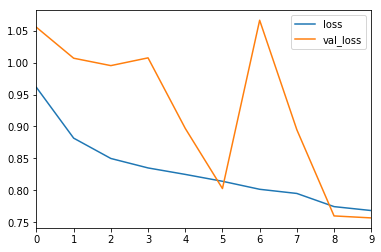

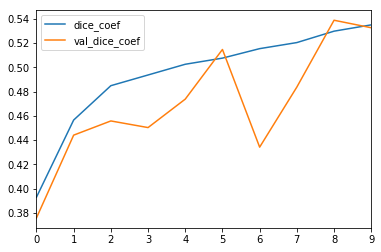

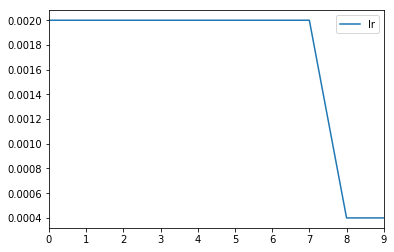

In [0]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('history.csv', index=False)

history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()
history_df[['lr']].plot()

In [0]:
model.load_weights('model_resunet_update.h5')

# Predict on Test Set

In [0]:
def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((350, 525), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [21]:
from tta_wrapper import tta_segmentation

model = tta_segmentation(model, h_flip=True, h_shift=(-10, 10), merge='mean')

In [22]:
best_threshold = 0.45
best_size = 15000

threshold = best_threshold
min_size = best_size

test_df = []
encoded_pixels = []
TEST_BATCH_SIZE = 500

for i in range(0, test_imgs.shape[0], TEST_BATCH_SIZE):
    batch_idx = list(
        range(i, min(test_imgs.shape[0], i + TEST_BATCH_SIZE))
    )

    test_generator = DataGenerator(
        batch_idx,
        df=test_imgs,
        shuffle=False,
        mode='predict',
        dim=(350, 525),
        reshape=(320, 480),
        n_channels=3,
        gamma=0.8,
        base_path='./test_images',
        target_df=sub_df,
        batch_size=1,
        n_classes=4
    )

    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1
    ) 
    # Predict out put shape is (320X480X4)
    # 4  = 4 classes, Fish, Flower, Gravel Surger.
    
    for j, idx in enumerate(batch_idx):
        filename = test_imgs['ImageId'].iloc[idx]
        image_df = sub_df[sub_df['ImageId'] == filename].copy()
        
        # Batch prediction result set
        pred_masks = batch_pred_masks[j, ]
        
        for k in range(pred_masks.shape[-1]):
            pred_mask = pred_masks[...,k].astype('float32') 
            
            if pred_mask.shape != (350, 525):
                pred_mask = cv2.resize(pred_mask, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
                
            pred_mask, num_predict = post_process(pred_mask, threshold, min_size)
            
            if num_predict == 0:
                encoded_pixels.append('')
            else:
                r = mask2rle(pred_mask)
                encoded_pixels.append(r)
                
sub_df['EncodedPixels'] = encoded_pixels

198/198 [==============================] - 69s 351ms/step


# Visualisation

Refers to [Understanding Clouds - EDA and Keras U-Net][1]

[1]: https://www.kaggle.com/dimitreoliveira/understanding-clouds-eda-and-keras-u-net

In [0]:
def rle_decode(mask_rle, shape=(1400, 2100)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')  # Needed to align to RLE direction

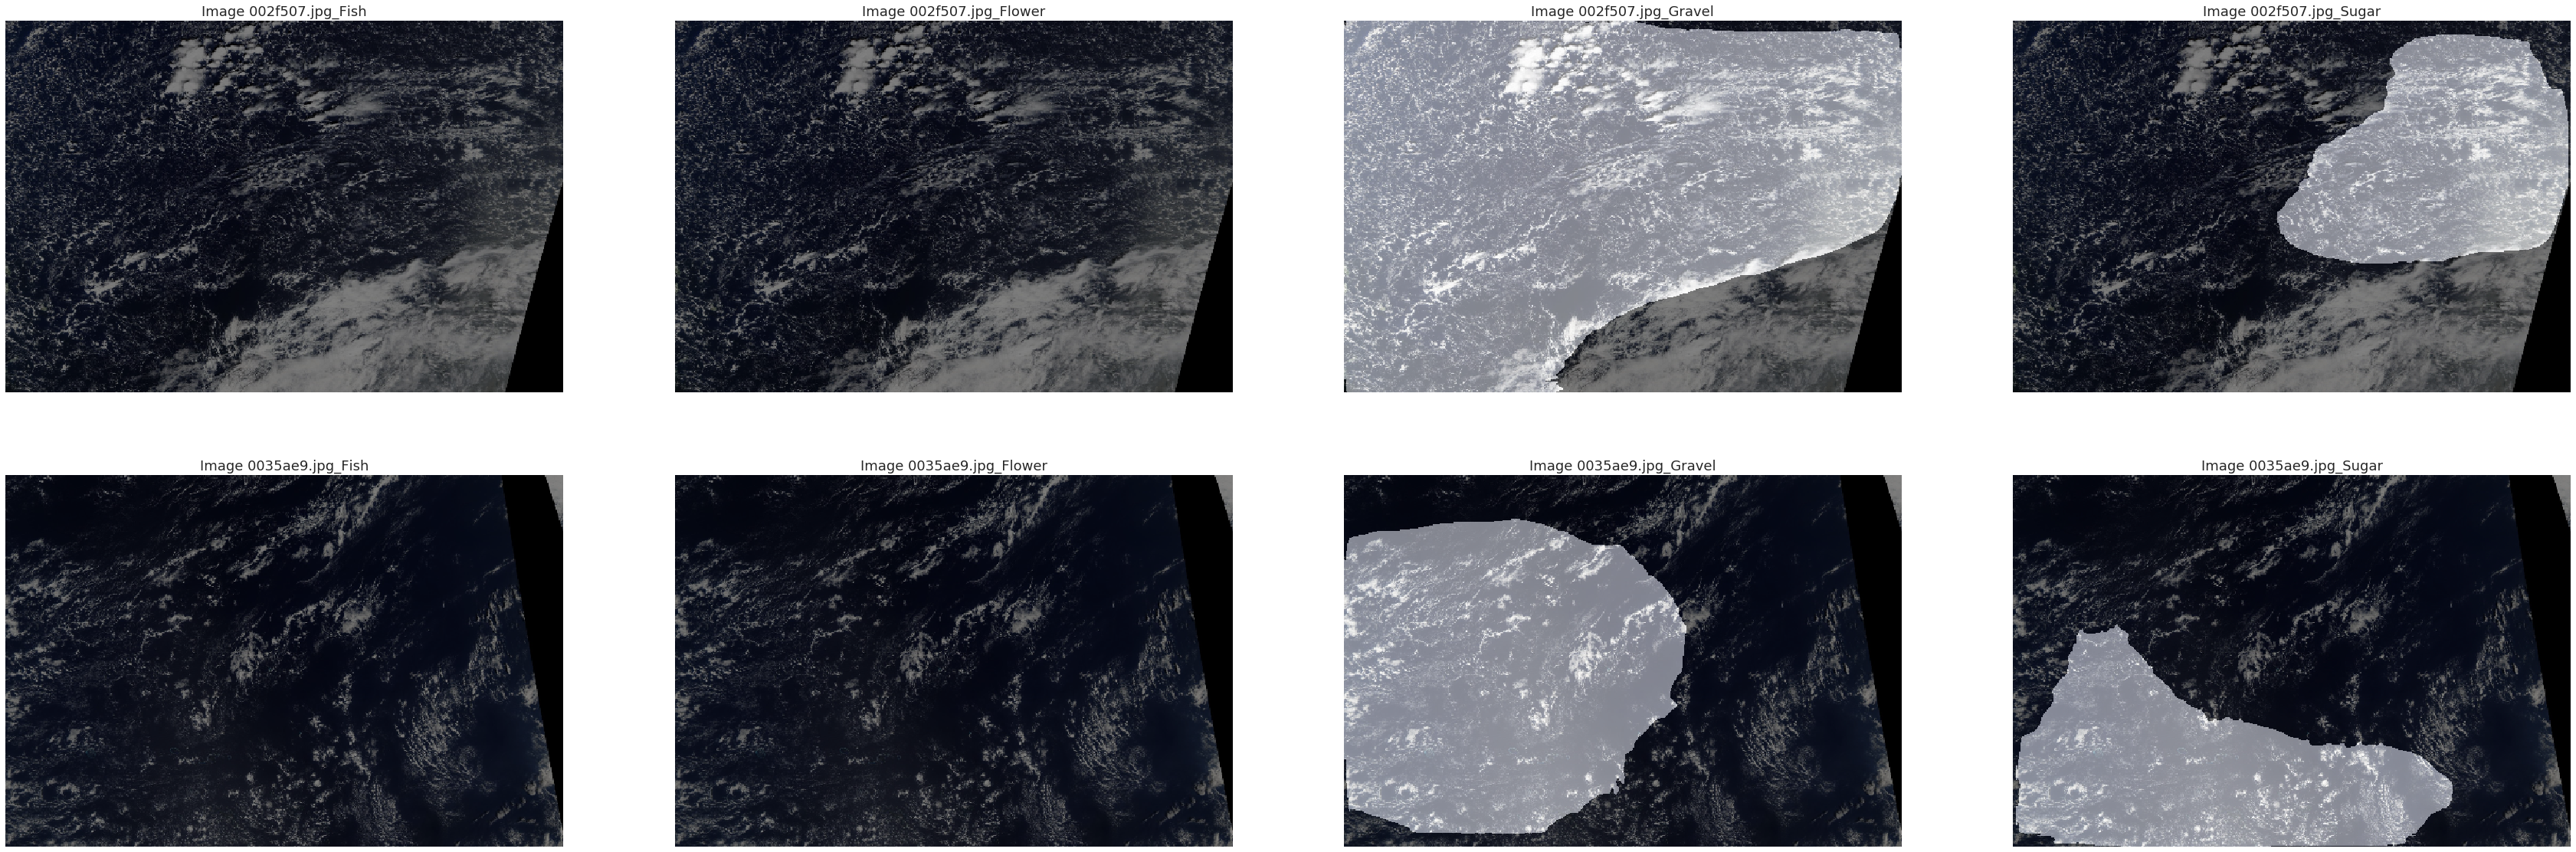

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
plt.figure(figsize=[60, 20])
for index, row in sub_df[:8].iterrows():
    img = cv2.imread("./test_images/%s" % row['ImageId'])[...,[2,1,0]]
    img = cv2.resize(img, (525, 350))
    mask_rle = row['EncodedPixels']
    try: # label might not be there!
        mask = rle_decode(mask_rle)
    except:
        mask = np.zeros((1400, 2100))
    plt.subplot(2, 4, index+1)
    plt.imshow(img)
    plt.imshow(rle2mask(mask_rle, img.shape), alpha=0.5, cmap='gray')
    plt.title("Image %s" % (row['Image_Label']), fontsize=18)
    plt.axis('off')    
    
plt.show()

# Submission

In [28]:
sub_df.to_csv('submission_resunet_update.csv', columns=['Image_Label', 'EncodedPixels'], index=False)
sub_df.head(10)

,Image_Label,EncodedPixels,ImageId
0,002f507.jpg_Fish,,002f507.jpg
1,002f507.jpg_Flower,,002f507.jpg
2,002f507.jpg_Gravel,4 334 355 333 701 348 1051 65788 66840 349 671...,002f507.jpg
3,002f507.jpg_Sugar,87330 11 87679 14 88029 18 88378 23 88727 25 8...,002f507.jpg
4,0035ae9.jpg_Fish,,0035ae9.jpg
5,0035ae9.jpg_Flower,,0035ae9.jpg
6,0035ae9.jpg_Gravel,80 188 431 187 772 218 1115 239 1462 253 1810 ...,0035ae9.jpg
7,0035ae9.jpg_Sugar,1324 13 1362 18 1677 9 1712 15 2018 19 2050 1 ...,0035ae9.jpg
8,0038327.jpg_Fish,,0038327.jpg
9,0038327.jpg_Flower,,0038327.jpg
